# Calculate marginal ice zone widths and areas from ACCESS-OM3

This notebook demonstrates how to calculate the marginal ice zone (MIZ) width and area from ACCESS-OM3 MOM–CICE–WW3 outputs.

MIZ defintions:
- Significant wave heights ($H_s$)
- Ice concentration ($a_\text{ice}$)
- Floe size ($r_a$)

In [1]:
### USER EDIT start
# esm_file = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"
esm_file = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_nomixing/experiment_datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_nomixing/experiment_datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-paper-figs/


In [2]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

In [3]:
client = Client(threads_per_worker=1)
client
# print(client.dashboard_link)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37279,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39159,Total threads: 1
Dashboard: /proxy/36003/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:41999,


### Open the intake-esm datastore

In [4]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [5]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [6]:
datastore_filtered = datastore.search(realm="seaIce", frequency="1mon")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
ANGLE,angle grid makes with latitude line on U grid,,,radians
ANGLET,angle grid makes with latitude line on T grid,,,radians
NCAT,category maximum thickness,,,m
Tair_m,air temperature,,time: mean,C
Tsfc_m,snow/ice surface temperature,,time: mean,C
...,...,...,...,...
vatm_m,atm velocity (y),,time: mean,m/s
vicen_m,"ice volume, categories",,time: mean,m
vort_m,strain rate (vorticity),,time: mean,%/day


### Load ice concentration, signficant wave height, and floe size

In [7]:
ds = datastore.search(variable=["aice_m", "wave_sig_ht_m", "fsdrad_m"], frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
ds_grid = datastore.search(variable=["tarea", "HTE"], frequency="fx", realm="seaIce").to_dask().compute()
ds_grid

ds = xr.merge([ds, ds_grid])
ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 40MB
Dimensions:        (time: 12, nj: 300, ni: 360)
Coordinates:
  * time           (time) object 96B 1900-01-16 12:00:00 ... 1900-12-16 12:00:00
    TLON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    TLAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ULON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ULAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    NLON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    NLAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ELON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ELAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: nj, ni
Data variables:
    aice_m         (time, nj, ni) float64 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht_m  (time, nj, ni) float64 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fsdrad_m       (time, nj, ni) float64 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tarea          (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    HTE            (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

In [8]:
ds_clim = ds.groupby('time.month').mean('time').compute()
ds_clim

<xarray.Dataset> Size: 59MB
Dimensions:        (month: 12, nj: 300, ni: 360)
Coordinates:
    TLON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    TLAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ULON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ULAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    NLON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    NLAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ELON           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
    ELAT           (nj, ni) float64 864kB nan nan nan nan ... nan nan nan nan
  * month          (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nj, ni
Data variables:
    aice_m         (month, nj, ni) float64 10MB nan nan nan nan ... nan nan nan
    wave_sig_ht_m  (month, nj, ni) float64 10MB nan nan nan nan ... nan nan nan
    fsdrad_m       (month, nj, ni) float64 10MB nan nan nan nan ... nan nan nan
    tarea          (month, nj, ni) float64 10MB nan nan nan nan ... nan nan nan
    HTE            (month, nj, ni) float64 10MB nan nan nan nan ... nan nan nan
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

### Load in observations (Fraser et al., 2025)

In [9]:
def ReadInAltika(version, year=2019):
    if version == '0.6':
        month_range = range(1,13)
        df = pd.concat((pd.read_csv('/home/566/nd0349/Fraser-2024/data/v0_6/' + str(year) + ("%02d" % (month,)) + '_output_v0_6.csv') 
                        for month in tqdm(month_range, total = len(month_range), desc = "Reading in Alex's data")),
                        ignore_index=True)
        
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
        
    
    elif version == '0.10':
        # Version 0.10
        df_raw = pd.read_csv('data/v0_10/' + str(year) + '_all_output_v0_10.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
    elif version == '0.11':
        # Version 0.11
        df_raw = pd.read_csv('data/v0_11/' + str(year) + '_all_output_v0_11.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
    elif version == '0.12':
        # Version 0.12
        df_raw = pd.read_csv('data/v0_12/' + str(year) + '_all_output_v0_12.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
        
    elif version == '0.15':
        # Version 0.15
        df_raw = pd.read_csv('/home/566/nd0349/Fraser-2024/data/v0_15/' + str(year) + '_all_output_v0_15.csv')
        row_temp = df_raw.loc[0,:]
        row_temp.values
        # Fill the first row with temporary data
        df = pd.DataFrame([row_temp], columns = df_raw.columns)
        
        numberRows,NumberCols = df_raw.shape
        
        for i in range(numberRows):
            row_temp = df_raw.loc[i,:]
            row = pd.DataFrame([row_temp], columns = df_raw.columns)
            if  (row['too_many_switches_flag'].values == 0) & (row['hit_continent_flag'].values == 0) & (row['ice_edge_diff_flag'].values == 0) & (row['latAtInnerMIZ'].values < row['latAtAltiKaEdge'].values) & (row['latAtInnerMIZ'].values < row['latAtMyEdge'].values) & (np.abs(row['lonAtInnerMIZ'].values - row['lonAtAltiKaEdge'].values) < 10):
                df = pd.concat([df,row])
        df.drop([0])
        
    # Add dates to dataframe
    df['date'] = pd.to_datetime(df["first_meas_time"])#, format='%Y-%m-%d').dt.round("d")
    df['day'] = pd.to_datetime(df['date']).dt.day
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    return df

In [12]:
from tqdm.notebook import tqdm

years = range(2013, 2024)
dfs = []

# swh_min = 10**-12
# swh_max = 100
# miz_max = 10000
# miz_min = -10**-12

for year in tqdm(years):
    # print(year)
    df = pd.DataFrame(ReadInAltika(version='0.15', year=year))
    df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
    df['date'] = pd.to_datetime(df["first_meas_time"]).dt.date # , format='%Y-%m-%d %H:%M:%S.%f').dt.date
    df['day'] = pd.to_datetime(df['date']).dt.day
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['mizwidth_lat'] = abs(df['latAtAltiKaEdge'] - df['latAtInnerMIZ'])*111.32 # Alex's conversion from latitudes to km

    dfs.append(df)
# Combine into one dataframe
df_all = pd.concat(dfs, ignore_index=True)
# df_tmp = df_all.copy()
# condition_met_df = (df_tmp['swhAtMyEdge'] < swh_max) & (df_tmp['swhAtMyEdge'] > swh_min) & (df_tmp['mizWidthAlongTrackFromAltikaEdge'] < miz_max) & (df_tmp['mizWidthAlongTrackFromAltikaEdge'] > miz_min)
# df_all = df_tmp.where(condition_met_df)
df_all.head()

2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


,first_meas_time,swhAtMyEdge,lonAtMyEdge,latAtMyEdge,lonAtAltiKaEdge,latAtAltiKaEdge,lonAtInnerMIZ,latAtInnerMIZ,mizWidthAlongTrackFromMyEdge,mizWidthAlongTrackFromAltikaEdge,date,day,year,month,mizwidth_lat
0,2013-03-14 06:29:45.868806,1.687726,144.227909,-65.075224,143.941111,-65.370226,143.705466,-65.611763,64.580466,29.058073,2013-03-14,14,2013,3,26.887899
1,2013-03-14 06:29:45.868806,1.687726,144.227909,-65.075224,143.941111,-65.370226,143.705466,-65.611763,64.580466,29.058073,2013-03-14,14,2013,3,26.887899
2,2013-03-14 07:20:03.662676,1.903122,1.938063,-68.331988,2.380483,-68.678470,3.743463,-69.687394,167.533329,124.858594,2013-03-14,14,2013,3,112.313420
3,2013-03-14 08:10:21.720821,2.011015,119.110686,-65.043592,118.766595,-65.397606,118.733795,-65.434442,47.005832,4.380543,2013-03-14,14,2013,3,4.100584
4,2013-03-14 09:00:39.517474,1.635128,339.407504,-70.235543,340.841359,-71.139443,341.304206,-71.418344,149.157700,35.263525,2013-03-14,14,2013,3,31.047259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85034,2023-12-31 13:46:56.304408,1.431014,263.561715,-69.320323,263.641003,-69.377669,264.172663,-69.751029,53.640213,46.521927,2023-12-31,31,2023,12,41.562435
85035,2023-12-31 15:27:31.973588,3.240307,235.614732,-67.075982,236.567656,-67.891133,238.883894,-69.651622,317.141347,217.521077,2023-12-31,31,2023,12,195.977635
85036,2023-12-31 16:17:49.576089,6.707534,354.160329,-65.087663,353.812745,-65.442032,349.820942,-68.919523,467.100096,424.384458,2023-12-31,31,2023,12,387.114298
85037,2023-12-31 18:48:43.156630,0.459674,189.876442,-70.513762,190.233347,-70.739887,190.342144,-70.811829,37.447967,8.968041,2023-12-31,31,2023,12,8.008583


In [17]:
# Average monthly
df_clim = df_all.groupby('month').mean(numeric_only=True)
df_clim.head()

,swhAtMyEdge,lonAtMyEdge,latAtMyEdge,lonAtAltiKaEdge,latAtAltiKaEdge,lonAtInnerMIZ,latAtInnerMIZ,mizWidthAlongTrackFromMyEdge,mizWidthAlongTrackFromAltikaEdge,day,year,mizwidth_lat
month,,,,,,,,,,,,
1,2.184007,166.430348,-67.106528,166.185463,-67.260895,166.206238,-67.713897,78.311200,55.655682,14.763496,2018.092891,50.428206
2,2.253309,180.162562,-68.080052,180.173450,-68.236231,180.146264,-68.592000,65.544679,44.085870,14.367722,2017.931523,39.604290
3,2.410002,188.731202,-68.150036,188.702315,-68.448503,188.702460,-68.930079,97.158424,60.083969,17.333527,2017.903988,53.609025
4,2.739153,179.746850,-66.636031,179.546947,-66.894250,179.511327,-67.828733,148.234037,114.969863,16.038139,2017.868374,104.026625
5,2.960517,176.019193,-64.907779,175.969736,-65.193372,175.948523,-66.395179,181.485997,145.995876,16.094722,2017.953533,133.785139


In [26]:
def _get_mask(ds, definition, hemisphere, threshold=None):
    # Set defaults for each definition
    defaults = {'wave_sig_ht': 0.05, 'aice': 0.8, 'fsdrad': 200}
    if threshold is None:
        try:
            threshold = defaults[definition]
        except KeyError:
            raise ValueError(f"Unknown definition: {definition}")
    
    # Hemisphere mask
    if hemisphere == 'south':
        hemi_mask = ds['TLAT'] < 0
    elif hemisphere == 'north':
        hemi_mask = ds['TLAT'] > 0
    else:
        raise ValueError("hemisphere must be 'north' or 'south'")

    # Base ice presence mask
    base_mask = ds['aice_m'] > 0.15

    # Definition-specific condition
    if definition == 'wave_sig_ht':
        cond = ds['wave_sig_ht_m'] > threshold
    elif definition == 'aice':
        cond = ds['aice_m'] < threshold
    elif definition == 'fsdrad':
        cond = ds['fsdrad_m'] < threshold
    elif definition in ['SIE', 'SIA']:
        cond = base_mask
    else:
        raise ValueError(f"Unknown definition: {definition}")

    return base_mask & cond & hemi_mask

def _integrate_width(width, ds, method):
    if method == 'simple':
        return width.sum(dim='nj', skipna=True)
    elif method == 'weighted':
        return (width * ds['tmask']).sum(dim='nj', skipna=True)
    else:
        raise ValueError(f"Unknown integration: {method}")

def _reduce_width(width, method, mask):
    if mask:
        width = width.where(width != 0)
    if method == 'median':
        return width.median(dim='ni', skipna=True)
    elif method == 'mean':
        return width.mean(dim='ni', skipna=True)
    else:
        raise ValueError(f"Unknown measure: {method}")

def calculate_miz_width(ds_cice, definition='wave', threshold=0.3, integration='simple', 
                        measure='median', mask=True, hemisphere='south'):
    mask_2d = _get_mask(ds_cice, definition, hemisphere, threshold)
    
    miz_width_2d = ds_cice['HTE'].where(mask_2d) / 1000 # m to km
    miz_width_1d = _integrate_width(miz_width_2d, ds_cice, integration)
    miz_width_reduced = _reduce_width(miz_width_1d, measure, mask)

    return xr.DataArray(
        miz_width_reduced,
        dims=miz_width_reduced.dims,
        coords={'month': ds_cice['month']},
        name='miz_width',
        attrs={
            'units': 'km',
            'description': f'MIZ width ({definition})'
        }
    )

In [27]:
hemisphere='south'
antarctic_miz_width_wave = calculate_miz_width(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
antarctic_miz_width_aice = calculate_miz_width(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
antarctic_miz_width_fsdrad = calculate_miz_width(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

In [28]:
hemisphere='north'
arctic_miz_width_wave = calculate_miz_width(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
arctic_miz_width_aice = calculate_miz_width(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
arctic_miz_width_fsdrad = calculate_miz_width(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

### Plot the different MIZ width defintions

In [29]:
def figure(region=None):
    plt.rcParams['font.size'] = 12
    fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.12)

    axes[0].text(0.0, 1.03, 'a) ANTARCTIC', fontsize=12, fontweight='bold', transform=axes[0].transAxes)
    axes[1].text(0.0, 1.03, 'b) ARCTIC', fontsize=12, fontweight='bold', transform=axes[1].transAxes)
    # axes[2].text(0.0, 1.03, 'c) ACCESS-OM3 - ACCESS-OM2', fontsize=12, fontweight='bold', transform=axes[2].transAxes)

    # axes[0].text(0.99, 1.03, "ANTARCTIC", ha='right', fontsize=12, transform=axes[0].transAxes)
    # axes[1].text(0.99, 1.03, "ARCTIC", ha='right', fontsize=12, transform=axes[1].transAxes)
    
    for i, ax in enumerate(axes):
        ax.plot(np.arange(1,13,1), np.full(12,0), lw=0.5, c='k')
        ax.set_xlim([1,12])
        ax.set_xticks(np.arange(1,13,1))
        ax.set_xlabel('Month')
    
    # axes[0].set_ylabel('Sea ice volume tendency\n(x1000 km$^3$ day$^{-1}$)')
        
    return fig, axes

Text(0, 0.5, 'MIZ width [km]')

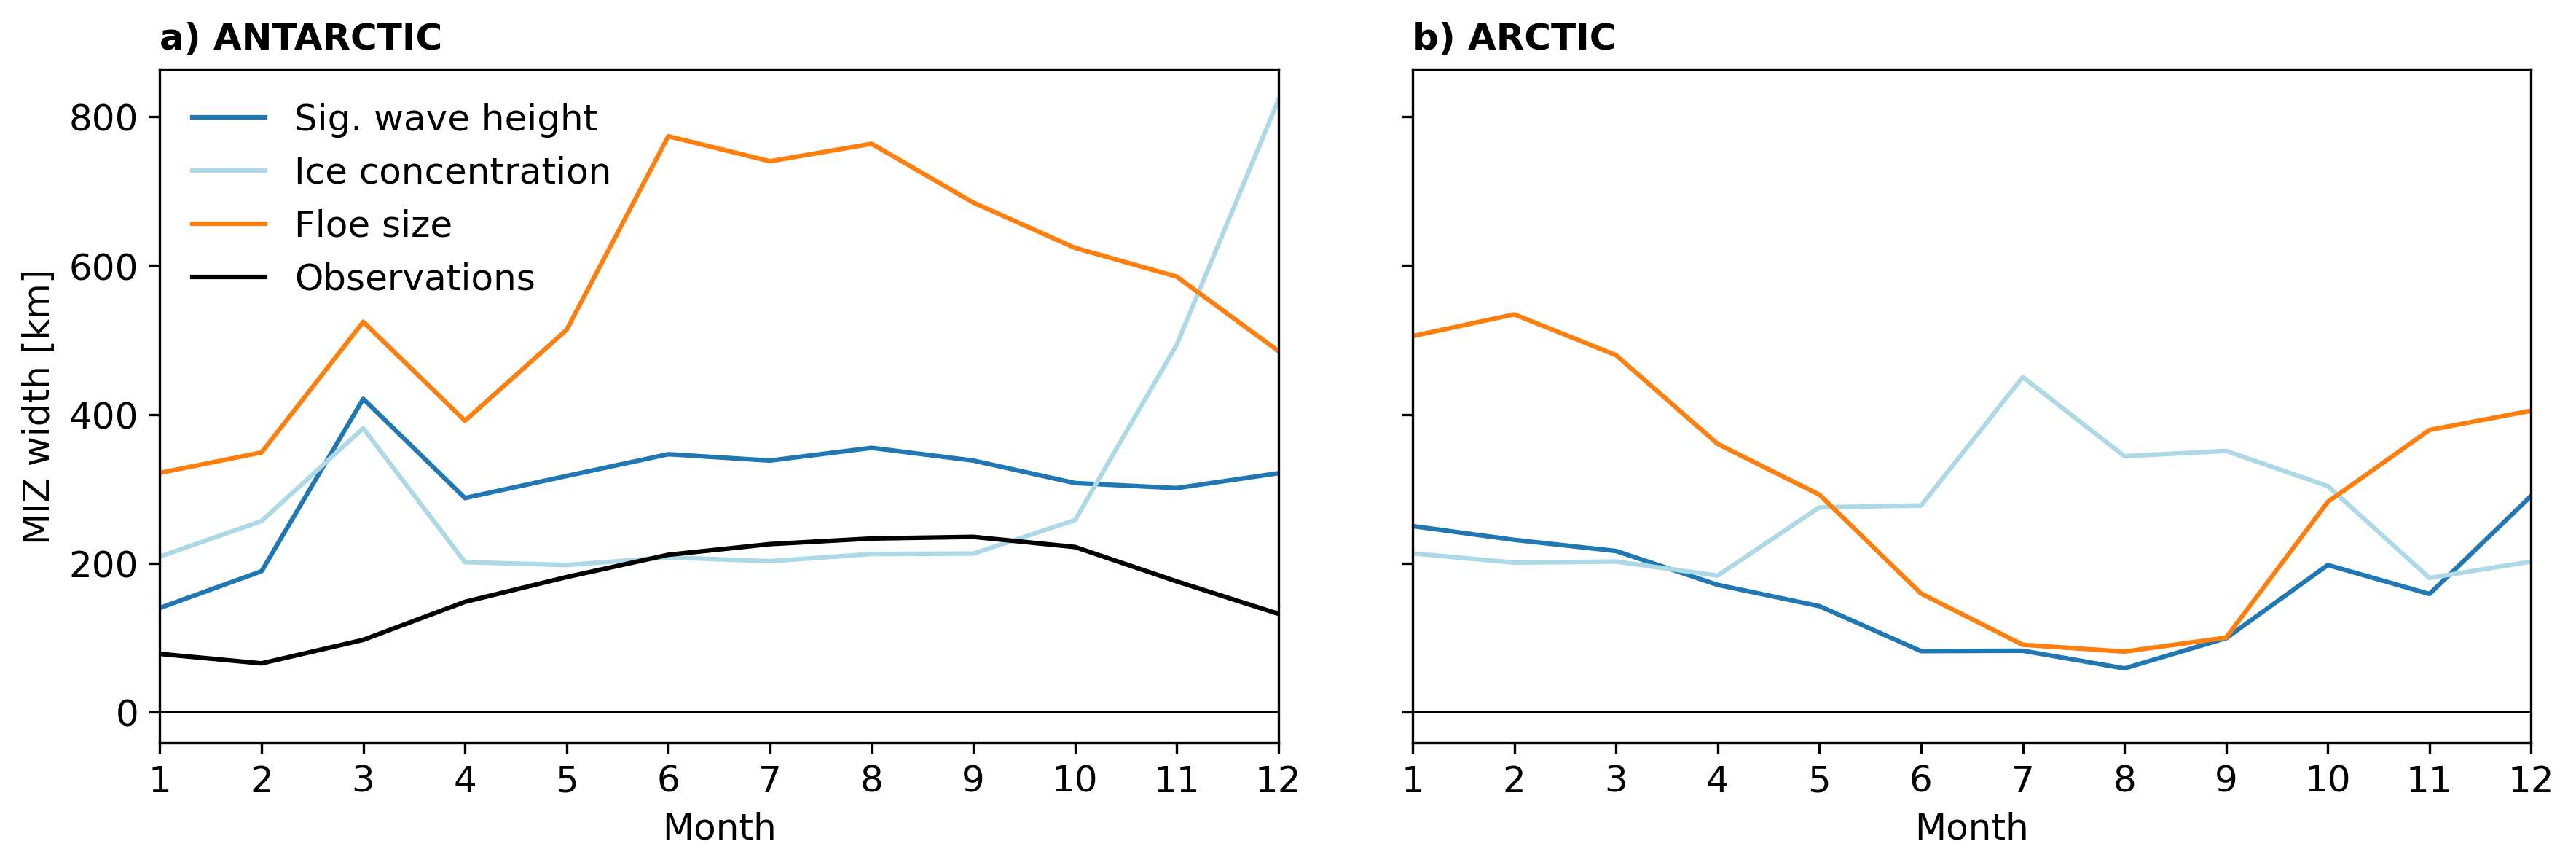

In [33]:
# region = 'ANTARCTICA'
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_width_wave, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_width_aice, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_width_fsdrad, label='Floe size')
axes[0].plot(x, df_clim['mizWidthAlongTrackFromMyEdge'], color='k', label="Observations")

axes[0].legend(frameon=False, ncols=1, fontsize=12)

axes[1].plot(x, arctic_miz_width_wave, label='Sig. wave height')
axes[1].plot(x, arctic_miz_width_aice, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_width_fsdrad, label='Floe size')

axes[0].set_ylabel("MIZ width [km]")

### MIZ area

In [36]:
def _integrate_area(ds, mask, definition):
    if definition == "SIA":
        return ds['tarea']*ds['aice_m'].where(mask).sum(dim=['ni', 'nj'])
    else:
        return ds['tarea'].where(mask).sum(dim=['ni', 'nj'])

def calculate_area(ds_cice, definition='wave', threshold=0.05, integration='simple', 
                        measure='median', mask=True, method='naive', hemisphere='south'):
    mask_2d = _get_mask(ds_cice, definition, hemisphere, threshold)
    
    sea_ice_extent = _integrate_area(ds_cice, mask_2d, definition) * 1e-12

    if definition in ["wave_sig_ht", "aice", "fsdrad"]:
        name = "MIZ area"
    elif definition == "SIE":
        name = "Sea ice extent"
    elif definition == "SIA":
        name = "Sea ice area"

    return xr.DataArray(
        sea_ice_extent,
        dims=sea_ice_extent.dims,
        coords={'month': ds_cice['month']},
        name=name,
        attrs={
            'units': '10^6 km^2',
            'description': f'MIZ extent ({definition})'
        }
    )


In [37]:
# Calculate Antarctic extents
hemisphere = "south"
antarctic_sie = calculate_area(ds_clim, definition='SIE', hemisphere=hemisphere)
antarctic_sia = calculate_area(ds_clim, definition='SIA', hemisphere=hemisphere)
antarctic_miz_extent_wave = calculate_area(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
antarctic_miz_extent_aice = calculate_area(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
antarctic_miz_extent_fsdrad = calculate_area(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

In [38]:
# Calculate Arctic extents
hemisphere = "north"
arctic_sie = calculate_area(ds_clim, definition='SIE', hemisphere=hemisphere)
arctic_sia = calculate_area(ds_clim, definition='SIA', hemisphere=hemisphere)
arctic_miz_extent_wave = calculate_area(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
arctic_miz_extent_aice = calculate_area(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
arctic_miz_extent_fsdrad = calculate_area(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

Text(0, 0.5, 'Sea Ice Area [$10^6$ km$^2$]')

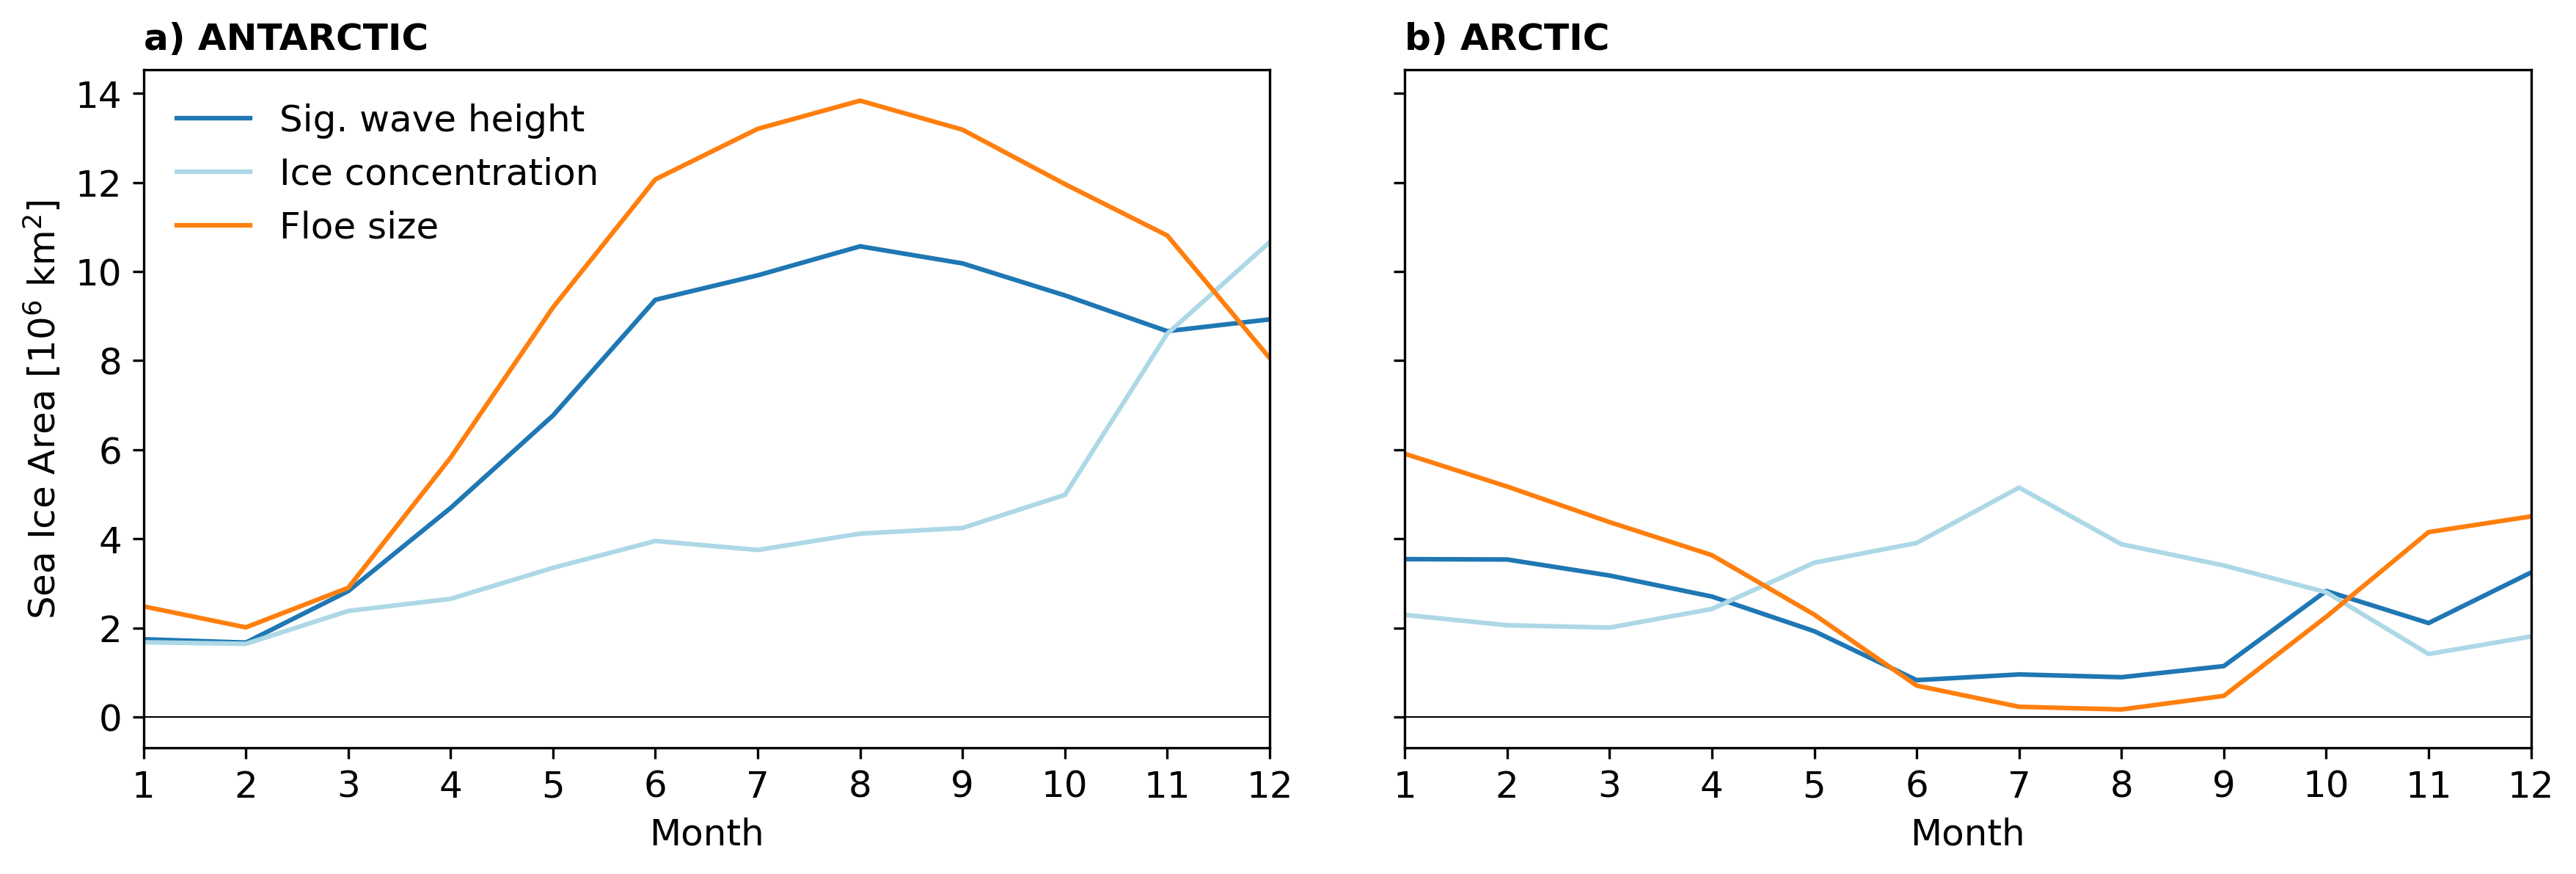

In [39]:
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_extent_wave, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_extent_aice, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_extent_fsdrad, label='Floe size')

axes[0].legend(frameon=False, ncols=1, fontsize=12)

axes[1].plot(x, arctic_miz_extent_wave, label='Sig. wave height')
axes[1].plot(x, arctic_miz_extent_aice, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_extent_fsdrad, label='Floe size')

axes[0].set_ylabel("Sea Ice Area [$10^6$ km$^2$]")

### MIZ fraction

Text(0, 0.5, 'Marginal Ice Zone Fraction')

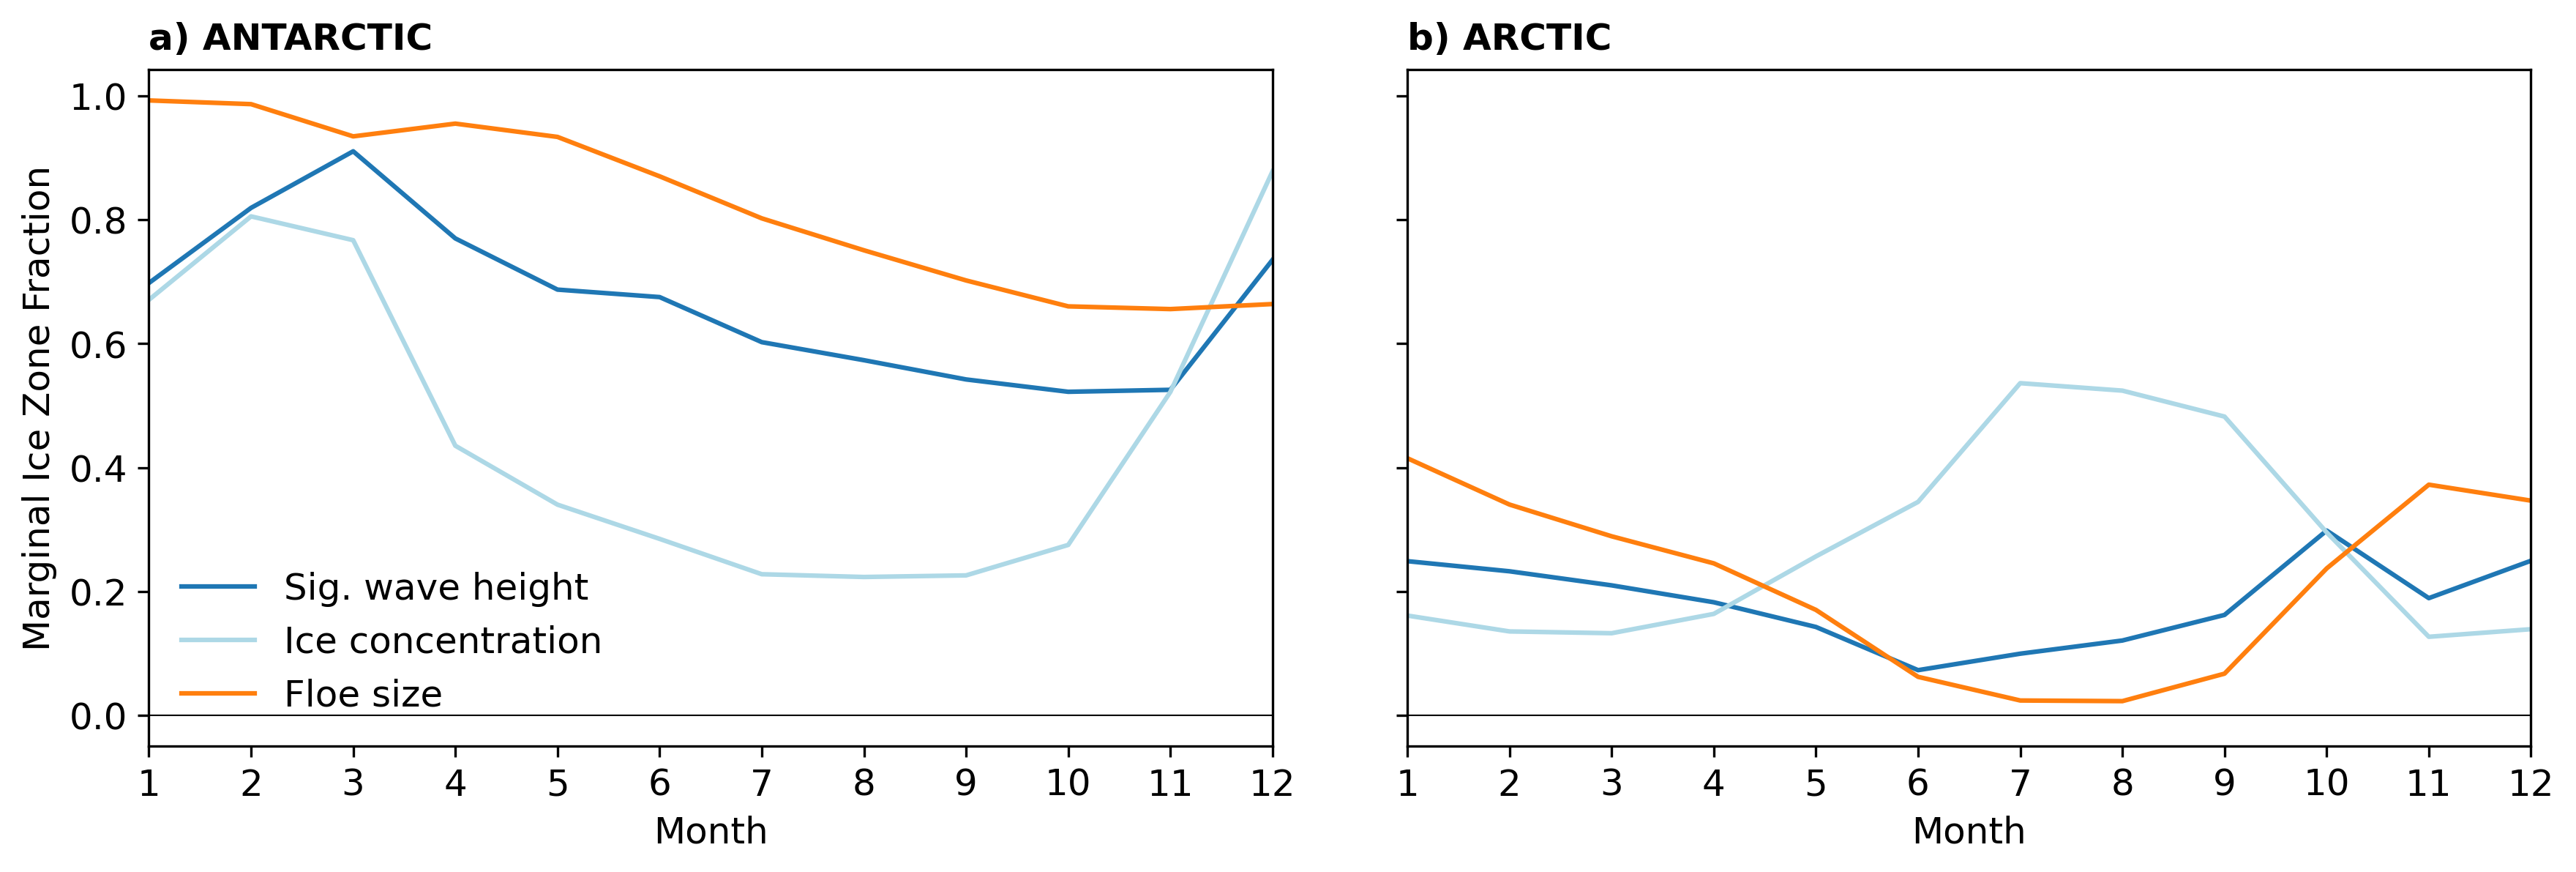

In [40]:
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_extent_wave/antarctic_sie, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_extent_aice/antarctic_sie, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_extent_fsdrad/antarctic_sie, label='Floe size')

axes[0].legend(frameon=False, ncols=1, fontsize=12, loc="lower left")

axes[1].plot(x, arctic_miz_extent_wave/arctic_sie, label='Sig. wave height')
axes[1].plot(x, arctic_miz_extent_aice/arctic_sie, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_extent_fsdrad/arctic_sie, label='Floe size')

axes[0].set_ylabel("Marginal Ice Zone Fraction")

In [ ]:
client.close()